In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# CSV 파일 불러오기
df = pd.read_csv('Dataset.csv', encoding='utf-8', delimiter='\t')

# 입력 텍스트와 레이블 분리
X = df['content']  # 입력 텍스트
y = df['label']  # 악플 여부(0: 악플, 1: 일반 텍스트)

# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# 시퀀스 패딩
max_sequence_length = 100  # 시퀀스 최대 길이 설정
X = pad_sequences(X, maxlen=max_sequence_length)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# 훈련 데이터와 검증 데이터로 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# 모델 평가
print('\n테스트 정확도: %.4f' % (model.evaluate(X_val, y_val)[1]))

Epoch 1/10
125/125 [==============================] - 20s 151ms/step - loss: 0.6573 - accuracy: 0.6096 - val_loss: 0.5904 - val_accuracy: 0.6970
Epoch 2/10
125/125 [==============================] - 20s 161ms/step - loss: 0.2098 - accuracy: 0.9298 - val_loss: 0.6843 - val_accuracy: 0.7100
Epoch 3/10
125/125 [==============================] - 20s 162ms/step - loss: -0.0327 - accuracy: 0.9930 - val_loss: 1.2067 - val_accuracy: 0.6670
Epoch 4/10
125/125 [==============================] - 20s 162ms/step - loss: -0.1009 - accuracy: 0.9952 - val_loss: 1.1582 - val_accuracy: 0.6750
Epoch 5/10
125/125 [==============================] - 20s 161ms/step - loss: -0.1445 - accuracy: 0.9961 - val_loss: 1.8697 - val_accuracy: 0.6725
Epoch 6/10
125/125 [==============================] - 20s 161ms/step - loss: -0.1787 - accuracy: 0.9967 - val_loss: 2.2168 - val_accuracy: 0.6630
Epoch 7/10
125/125 [==============================] - 20s 163ms/step - loss: -0.2009 - accuracy: 0.9970 - val_loss: 1.9128 - v

인공신경망을 이용해 지도학습을 시킨 모습이다. 0.6920의 정확도를 보였다. 위에 파악한 데이터의 특징들을 가미하여 정확도를 높여보는 시도를 해보겠다.

Epoch 1/10
125/125 [==============================] - 21s 147ms/step - loss: 0.6445 - accuracy: 0.6171 - val_loss: 0.5522 - val_accuracy: 0.7100
Epoch 2/10
125/125 [==============================] - 20s 160ms/step - loss: 0.1816 - accuracy: 0.9294 - val_loss: 0.6167 - val_accuracy: 0.7370
Epoch 3/10
125/125 [==============================] - 20s 159ms/step - loss: -0.0352 - accuracy: 0.9921 - val_loss: 0.7230 - val_accuracy: 0.7095
Epoch 4/10
125/125 [==============================] - 20s 160ms/step - loss: -0.1062 - accuracy: 0.9960 - val_loss: 1.5172 - val_accuracy: 0.7065
Epoch 5/10
125/125 [==============================] - 20s 157ms/step - loss: -0.1433 - accuracy: 0.9964 - val_loss: 1.4331 - val_accuracy: 0.7085
Epoch 6/10
125/125 [==============================] - 20s 158ms/step - loss: -0.1781 - accuracy: 0.9964 - val_loss: 1.6188 - val_accuracy: 0.7070
Epoch 7/10
125/125 [==============================] - 20s 158ms/step - loss: -0.2058 - accuracy: 0.9971 - val_loss: 1.8190 - v

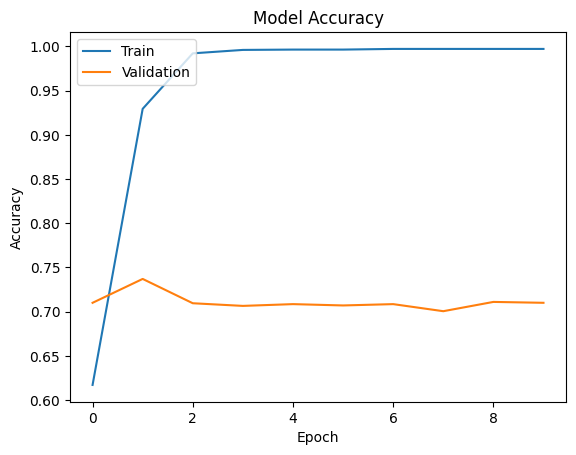

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [21]:
df = pd.read_csv('Dataset.csv', encoding='utf-8', delimiter='\t')
# 특징 엔지니어링: 댓글의 길이, 단어의 평균 길이, 단어 수 추가
df['comment_length'] = df['content'].apply(lambda x: len(x))
df['average_word_length'] = df['content'].apply(lambda x: np.mean([len(word) for word in x.split()]))
df['word_count'] = df['content'].apply(lambda x: len(x.split()))

# 악플과 비악플로 분리
df_malicious = df[df['label'] == 0]
df_non_malicious = df[df['label'] == 1]

# 악플 데이터에서 자주 등장하는 단어 추출
vectorizer_malicious = CountVectorizer()
X_malicious = vectorizer_malicious.fit_transform(df_malicious['content'])
malicious_words = vectorizer_malicious.get_feature_names_out()

# 비악플 데이터에서 자주 등장하는 단어 추출
vectorizer_non_malicious = CountVectorizer()
X_non_malicious = vectorizer_non_malicious.fit_transform(df_non_malicious['content'])
non_malicious_words = vectorizer_non_malicious.get_feature_names_out()

# 가장 자주 등장하는 단어들을 합친 후 토크나이저에 추가
# malicious_words와 non_malicious_words의 길이를 맞춤
max_word_count = min(len(malicious_words), len(non_malicious_words))
malicious_words = list(set(malicious_words))[:max_word_count]
non_malicious_words = list(set(non_malicious_words))[:max_word_count]

# 두 리스트 결합
common_words = list(set(malicious_words + non_malicious_words))

# 입력 텍스트와 레이블 분리
X = df['content']  # 입력 텍스트
y = df['label']  # 악플 여부(0: 악플, 1: 일반 텍스트)

# 텍스트 전처리: 토큰화, 불용어 처리 등
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1

max_sequence_length = 100  # 시퀀스 최대 길이 설정
X = pad_sequences(X, maxlen=max_sequence_length)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 구성
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
print(history.history)

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print('\n테스트 손실: %.4f' % loss)
print('테스트 정확도: %.4f' % accuracy)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve

# 학습 곡선 그리기
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 혼동 행렬 계산
y_pred = model.predict_classes(X_test)
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 그리기
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-malicious', 'Malicious'], rotation=45)
plt.yticks(tick_marks, ['Non-malicious', 'Malicious'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Precision-Recall 곡선 계산
y_pred_prob = model.predict_proba(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Precision-Recall 곡선 그리기
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()